<a href="https://colab.research.google.com/github/WRFitch/fyp/blob/main/src/fyp_ai_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI data analysis

## Notes on Use. 
Because fastai can be a bit silly, restart runtime when you have to. Yes, it's very annoying. 

### Setup
- Install & import necessary libraries

In [ ]:
# Sometimes the colab fastai version can be wrong, so we reinstall with no cache
# uninstalling, reinstalling, and restarting runtime should fix any major issues. 
!pip uninstall -y fastai
!pip install -U --no-cache-dir fastai

In [ ]:
# TODO clean up imports - I can't seriously need all this
import os
import numpy as np
import pandas as pd

from fastai import *
from fastai.tabular import *
from fastai.vision import *
from fastai.vision.all import *
from google.colab import drive
import matplotlib.pyplot as plt

drive.mount('/content/drive')

In [2]:
%rm -rf /content/fyp

In [3]:
%cd /content
!git clone https://github.com/WRFitch/fyp.git

/content
Cloning into 'fyp'...
remote: Enumerating objects: 415, done.
remote: Counting objects: 100% (415/415), done.
remote: Compressing objects: 100% (333/333), done.
remote: Total 927 (delta 274), reused 146 (delta 82), pack-reused 512
Receiving objects: 100% (927/927), 155.06 MiB | 34.08 MiB/s, done.
Resolving deltas: 100% (529/529), done.


In [4]:
# Import fyputil library
%cd /content/fyp/src/fyputil
import constants as c
import fyp_utils as fyputil
%cd /content

/content/fyp/src/fyputil
/content


In [5]:
drive_path = "/content/drive/MyDrive/"
png_dir = c.png_dir
model_dir = c.model_dir

CO_band = c.CO_band
HCHO_band = c.HCHO_band
NO2_band = c.NO2_band
O3_band = c.O3_band
SO2_band = c.SO2_band
CH4_band = c.CH4_band

lon = c.lon
lat = c.lat

In [6]:
# Import data from google drive 
# This is getting really slow. Is there too much data? If so, slice to only use 
# every tenth image so we still get a decently stratified set. 
imgs = get_image_files(c.png_dir)

In [7]:
len(imgs)

8481

### Data Setup

#### Sort Dataframes

In [8]:
# Parse CSVs into pandas dataframes
# TODO rewrite so we aren't deleting columns directly - do it properly! Incorporate these into one csv export in the 
#      output pipeline 
co_df = pd.read_csv(f"{c.data_dir}/{c.CO_band}.csv")
del co_df[".geo"]
hcho_df = pd.read_csv(f"{c.data_dir}/{c.HCHO_band}.csv")
del hcho_df[".geo"]
no2_df = pd.read_csv(f"{c.data_dir}/{c.NO2_band}.csv")
del no2_df[".geo"]
o3_df = pd.read_csv(f"{c.data_dir}/{c.O3_band}.csv")
del o3_df[".geo"]
so2_df = pd.read_csv(f"{c.data_dir}/{c.SO2_band}.csv")
del so2_df[".geo"]
ch4_df = pd.read_csv(f"{c.data_dir}/{c.CH4_band}.csv")
del ch4_df[".geo"]

In [ ]:
# Incorporate individual csvs into one ghg dataframe. Badly. 
# TODO fix this so we aren't repeating the same thing over and over
mrg_params = [c.lon, c.lat, 'system:index']
# somehow this means "intersect". We're taking the intersect so we know we have common values. 
mrg_type = 'inner'

intersect = pd.merge(so2_df, ch4_df, how=mrg_type, on=mrg_params)
intersect = pd.merge(intersect, co_df, how=mrg_type, on=mrg_params)
intersect = pd.merge(intersect, hcho_df, how=mrg_type, on=mrg_params)
intersect = pd.merge(intersect, no2_df, how=mrg_type, on=mrg_params)
intersect = pd.merge(intersect, o3_df, how=mrg_type, on=mrg_params)

print(intersect.shape)
intersect.iloc[0:4] 

In [ ]:
raw_ghg_df = intersect.copy()

for index, row in intersect.iterrows():
  coords = (row.longitude, row.latitude)
  #print(coords)
  if not fyputil.imgExported(coords):
    #print(f"dropping {fyputil.getFilepath(coords)} from row {index}")
    # TODO implement this in a way that doesn't recreate the dataframe thousands of times
    raw_ghg_df = raw_ghg_df.drop(index=index)

# Normalise ghg numbers so they can be more easily predicted by the network, and 
# fit into a consistent, normalised y_range 
ghg_df = raw_ghg_df.copy()
ghg_df = fyputil.normGhgDfProperly(ghg_df)

print(intersect.shape)
print(raw_ghg_df.shape)
raw_ghg_df.iloc[0:10]

In [ ]:
ghg_df

In [46]:
ghg_df.to_csv(f"{c.data_dir}/good_ghg.csv")

In [70]:
def copyUsableImages():
  for idx, row in ghg_df.iterrows():
    coords = (row.longitude, row.latitude)
    filename = fyputil.getFilepath(coords)
    os.system(f"cp {filename} {c.data_dir}/png_tfms/orig/normal/{row.longitude}_{row.latitude}")
    print(idx)

In [72]:
print(os.system(f"ls /content/drive/MyDrive/img_export/png_tfms/orig/normal"))

0


In [71]:
copyUsableImages()

134
135
136
137
138
139
140
142
143
144
145
147
148
149
150
151
152
153
154
156
157
158
159
161
162
163
164
165
166
167
170
171
172
176
177
180
181
182
183
184
185
186
187
189
190
191
193
194
197
200
201
202
203
204
205
206
207
208
210
211
212
213
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
232
233
234
235
237
238
239
240
241
242
243
244
245
248
251
252
254
255
256
258
259
260
261
262
263
264
265
804
805
806
807
808
809
810
812
813
814
815
817
818
819
820
821
822
823
824
826
827
828
829
831
832
833
834
835
836
837
840
841
842
846
847
850
851
852
853
854
855
856
857
859
860
861
863
864
867
870
871
872
873
874
875
876
877
878
880
881
882
883
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
902
903
904
905
907
908
909
910
911
912
913
914
915
918
921
922
924
925
926
928
929
930
931
932
933
934
935
1072
1073
1074
1075
1076
1077
1078
1080
1081
1082
1083
1085
1086
1087
1088
1089
1090
1091
1092
1094
1095
1096
1097
1099
1100
1101
1102
1103
1104
1105
1108
1109


#### Sort Data Import Methods

In [25]:
def getGhgsAsArr(img_path):
  return np.array(fyputil.getGhgs(img_path, ghg_df))

def imgIsInDf(img_path):
  # Probably a faster way to do this
  val = fyputil.getGhgs(img_path, ghg_df)
  if val == None: return False 
  if len(val) == 6: return True 
  return False

def getGhgImgs(path):
  return get_image_files(path).filter(imgIsInDf)

In [21]:
len(getGhgImgs(c.png_dir))

1886

In [26]:
# TODO implement multiple transforms pipeline
# TODO revisit image normalisation

mean,std = [0.5]*3,[0.5]*3
mean,std = broadcast_vec(1, 4, mean, std)

ghg_block = DataBlock(
    blocks = (ImageBlock, RegressionBlock),
    get_items = getGhgImgs,
    get_y = getGhgsAsArr,
    item_tfms = Resize(224),
    batch_tfms = aug_transforms(size=224)
)

ghg_dl = ghg_block.dataloaders(png_dir)

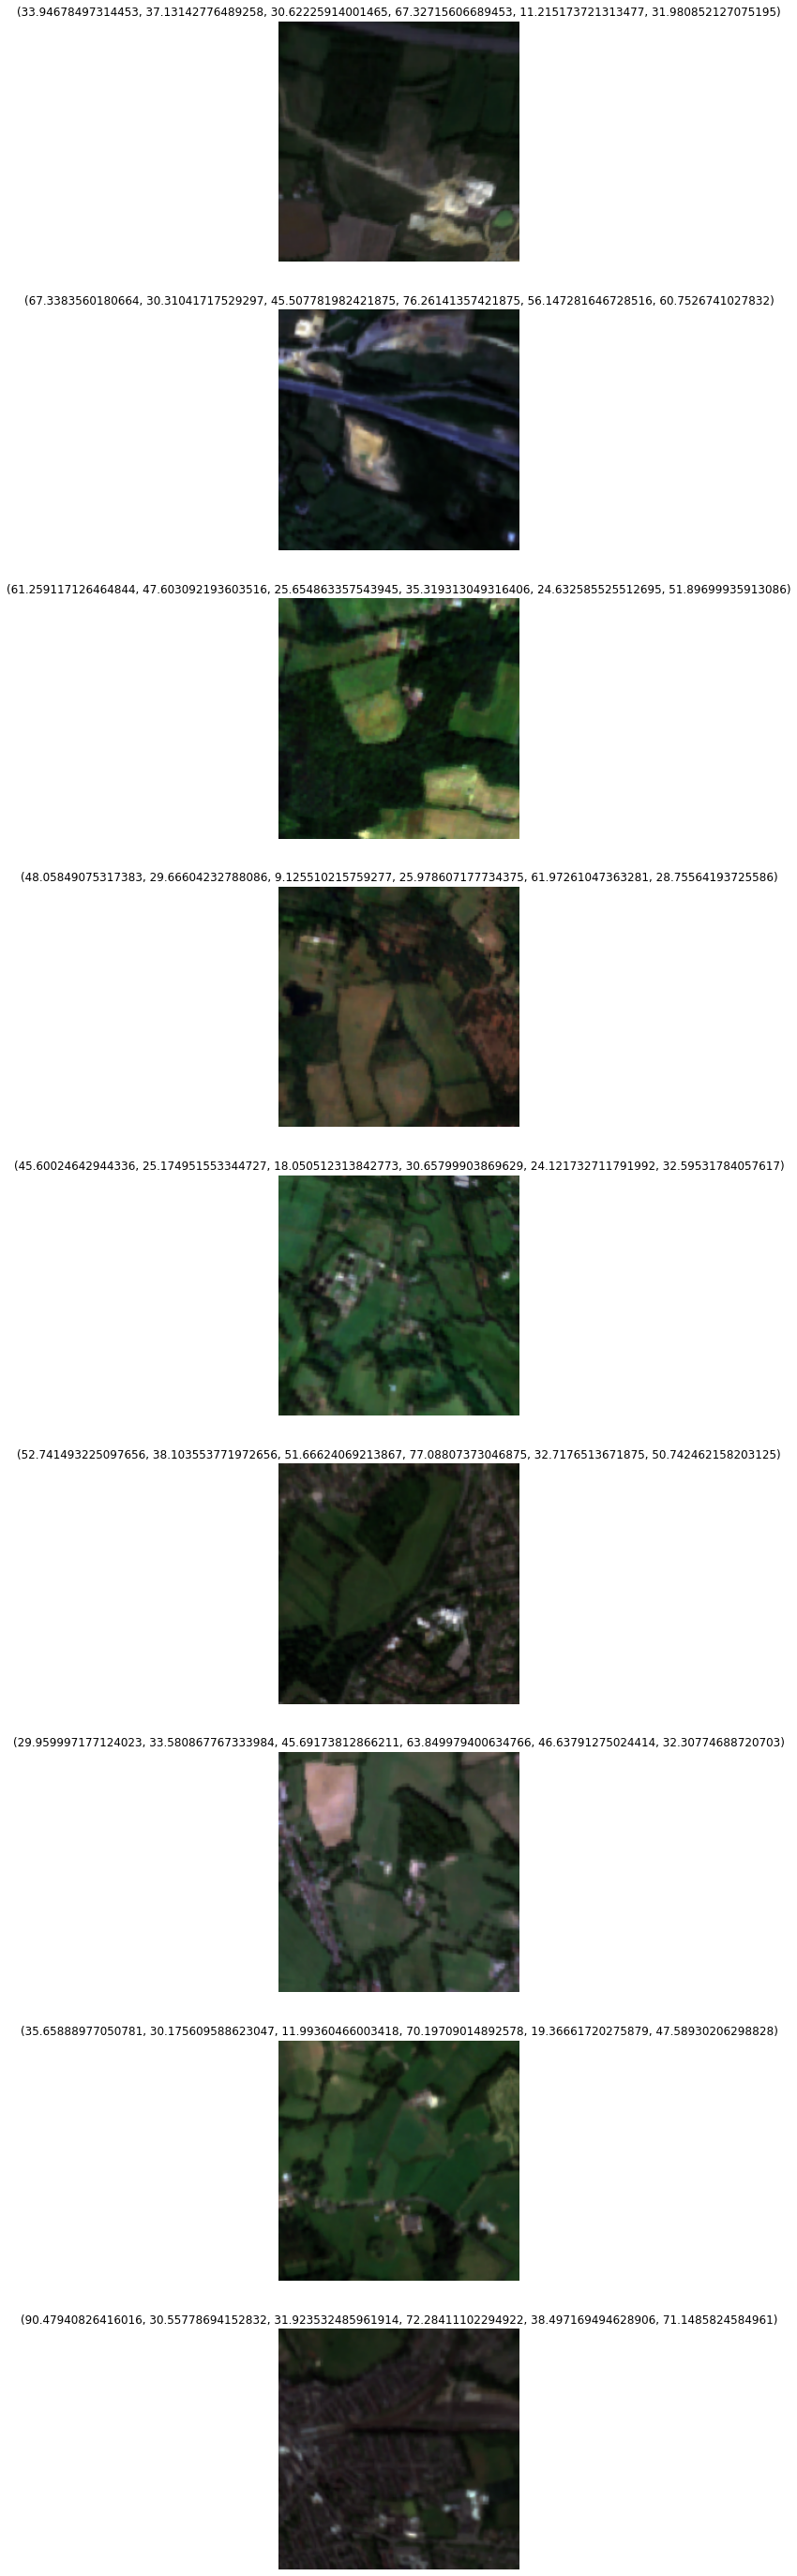

In [27]:
ghg_dl.show_batch(nrows=9, max_n=9, figsize = (50,50))

In [28]:
ghg_block.summary(c.png_dir)

Setting-up type transforms pipelines
Found 1886 items
2 datasets of sizes 1509,377
Setting up Pipeline: PILBase.create
Setting up Pipeline: getGhgsAsArr -> RegressionSetup -- {'c': None}

Building one sample
  Pipeline: PILBase.create
    starting from
      /content/drive/MyDrive/img_export/png/-0.7860258736045813_51.37015952237484.png
    applying PILBase.create gives
      PILImage mode=RGB size=160x161
  Pipeline: getGhgsAsArr -> RegressionSetup -- {'c': None}
    starting from
      /content/drive/MyDrive/img_export/png/-0.7860258736045813_51.37015952237484.png
    applying getGhgsAsArr gives
      [33.61568937 49.4820759  40.36139251 53.30154609 44.05102187 12.11308946]
    applying RegressionSetup -- {'c': None} gives
      tensor([33.6157, 49.4821, 40.3614, 53.3015, 44.0510, 12.1131])

Final sample: (PILImage mode=RGB size=160x161, tensor([33.6157, 49.4821, 40.3614, 53.3015, 44.0510, 12.1131]))


Found 1886 items
2 datasets of sizes 1509,377
Setting up Pipeline: PILBase.create


## Training

### Bespoke methods 

### Image Recognition and Feature Extraction. 

- Train image-based predictor to guess greenhouse gas concentrations based on 1km square of land. 
  - Transfer an ImageNet predictor to work top-down
  - Start by predicting one ghg and expand from there
- Use image predictor to extract a basic feature set by slicing the network at different points. The idea is to limit the amount of data going into the tabular recommender, while transferring as much useful data as possible. We want to implicitly extract GHG-emitting features of each image without losing any detail, as a form of convolutional preprocessing. 


In [29]:
# uses a regression approach.
# TODO analyse metrics. Really it doesn't seem to matter so long as everything 
#      is evaluated equally, but I'd like to be sure - ask Allan on Monday. 
# TODO Further experimentation with resnet size is necessary. 34 provides _ok_ 
#      predictions, longer is usually better but it takes longer to train. While
#      I'm iterating on design, performance is necessary. Once I'm at a stage 
#      where I can export my model and use it as is, I'll take the time to train 
#      a much larger network. 
learn = cnn_learner(ghg_dl, resnet152, y_range=(0, 100),  metrics=rmse)

In [30]:
name = "learner test"
learn.save(name)

Path('models/learner test.pth')

In [ ]:
learn.load(name)

SuggestedLRs(lr_min=3.981071586167673e-07, lr_steep=5.754399353463668e-06)

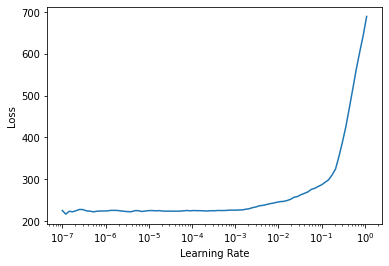

In [43]:
# TODO examine 3d representation of problem space re: local optima 
learn.lr_find()

In [36]:
lr = 0.05
finelr = 0.0019
xfinelr = 0.0001
xxfinelr = 2e-6

In [33]:
# epochs = 5
learn.fine_tune(5, lr)

epoch,train_loss,valid_loss,_rmse,time
0,1251.591919,1552.050781,39.396072,00:37


epoch,train_loss,valid_loss,_rmse,time
0,691.342529,2300.635010,47.964939,00:46
1,538.445618,1107.120850,33.273426,00:44
2,456.324432,556.857605,23.597830,00:44
3,395.142792,395.613556,19.890038,00:44
4,356.671692,335.778778,18.324266,00:44


In [35]:
# Saving mid-training, so I can figure out a decent training pathway
learn.save("mid-training")

Path('models/mid-training.pth')

In [36]:
learn.load("mid-training")

In [74]:
learn.fine_tune(30, finelr)

epoch,train_loss,valid_loss,_rmse,time
0,197.661255,261.747314,16.178606,00:34


epoch,train_loss,valid_loss,_rmse,time
0,201.600891,280.277649,16.741493,00:43
1,201.282913,247.832916,15.742710,00:45
2,200.165298,249.627502,15.799605,00:44
3,196.409592,287.265137,16.948896,00:44
4,195.723526,243.925812,15.618124,00:44
5,194.568192,273.242493,16.530046,00:44
6,194.379196,246.263123,15.692772,00:44
7,193.535614,240.770325,15.516775,00:44
8,197.205444,279.597656,16.721174,00:44
9,202.204178,264.059235,16.249901,00:44


In [42]:
learn.save("fine-tuning")

Path('models/fine-tuning.pth')

In [73]:
learn.save("fine-tuning-2")

Path('models/fine-tuning-2.pth')

In [ ]:
learn.load("fine-tuning")

In [39]:
learn.fine_tune(5, xfinelr)

epoch,train_loss,valid_loss,_rmse,time
0,296.274231,305.799683,17.487127,00:35


epoch,train_loss,valid_loss,_rmse,time
0,294.046051,300.931976,17.347391,00:44
1,298.457916,287.129700,16.944901,00:44
2,297.049591,295.288635,17.183966,00:44
3,292.938965,306.749695,17.514271,00:44
4,291.223755,291.845398,17.083481,00:44


In [38]:
learn.save("xfine-tuning")

Path('models/xfine-tuning.pth')

In [ ]:
learn.load("xfine-tuning")

In [37]:
# at this point, it doesn't seem to make any difference 
# There appears to be a point of diminishing returns, where rmse is just the 
# error rate of the given data. 
learn.fine_tune(10, xxfinelr)

epoch,train_loss,valid_loss,_rmse,time
0,300.532745,296.488220,17.218834,00:36


epoch,train_loss,valid_loss,_rmse,time
0,296.958344,293.299622,17.125990,00:44
1,294.233856,302.464966,17.391520,00:44
2,291.282837,293.456146,17.130560,00:44
3,294.024719,301.715881,17.369970,00:44
4,296.169342,287.167511,16.946016,00:44
5,295.395752,304.662872,17.454596,00:44
6,295.388489,297.099976,17.236588,00:44
7,297.068115,302.645477,17.396708,00:44
8,297.201813,292.348724,17.098209,00:44
9,294.335571,288.223511,16.977146,00:44


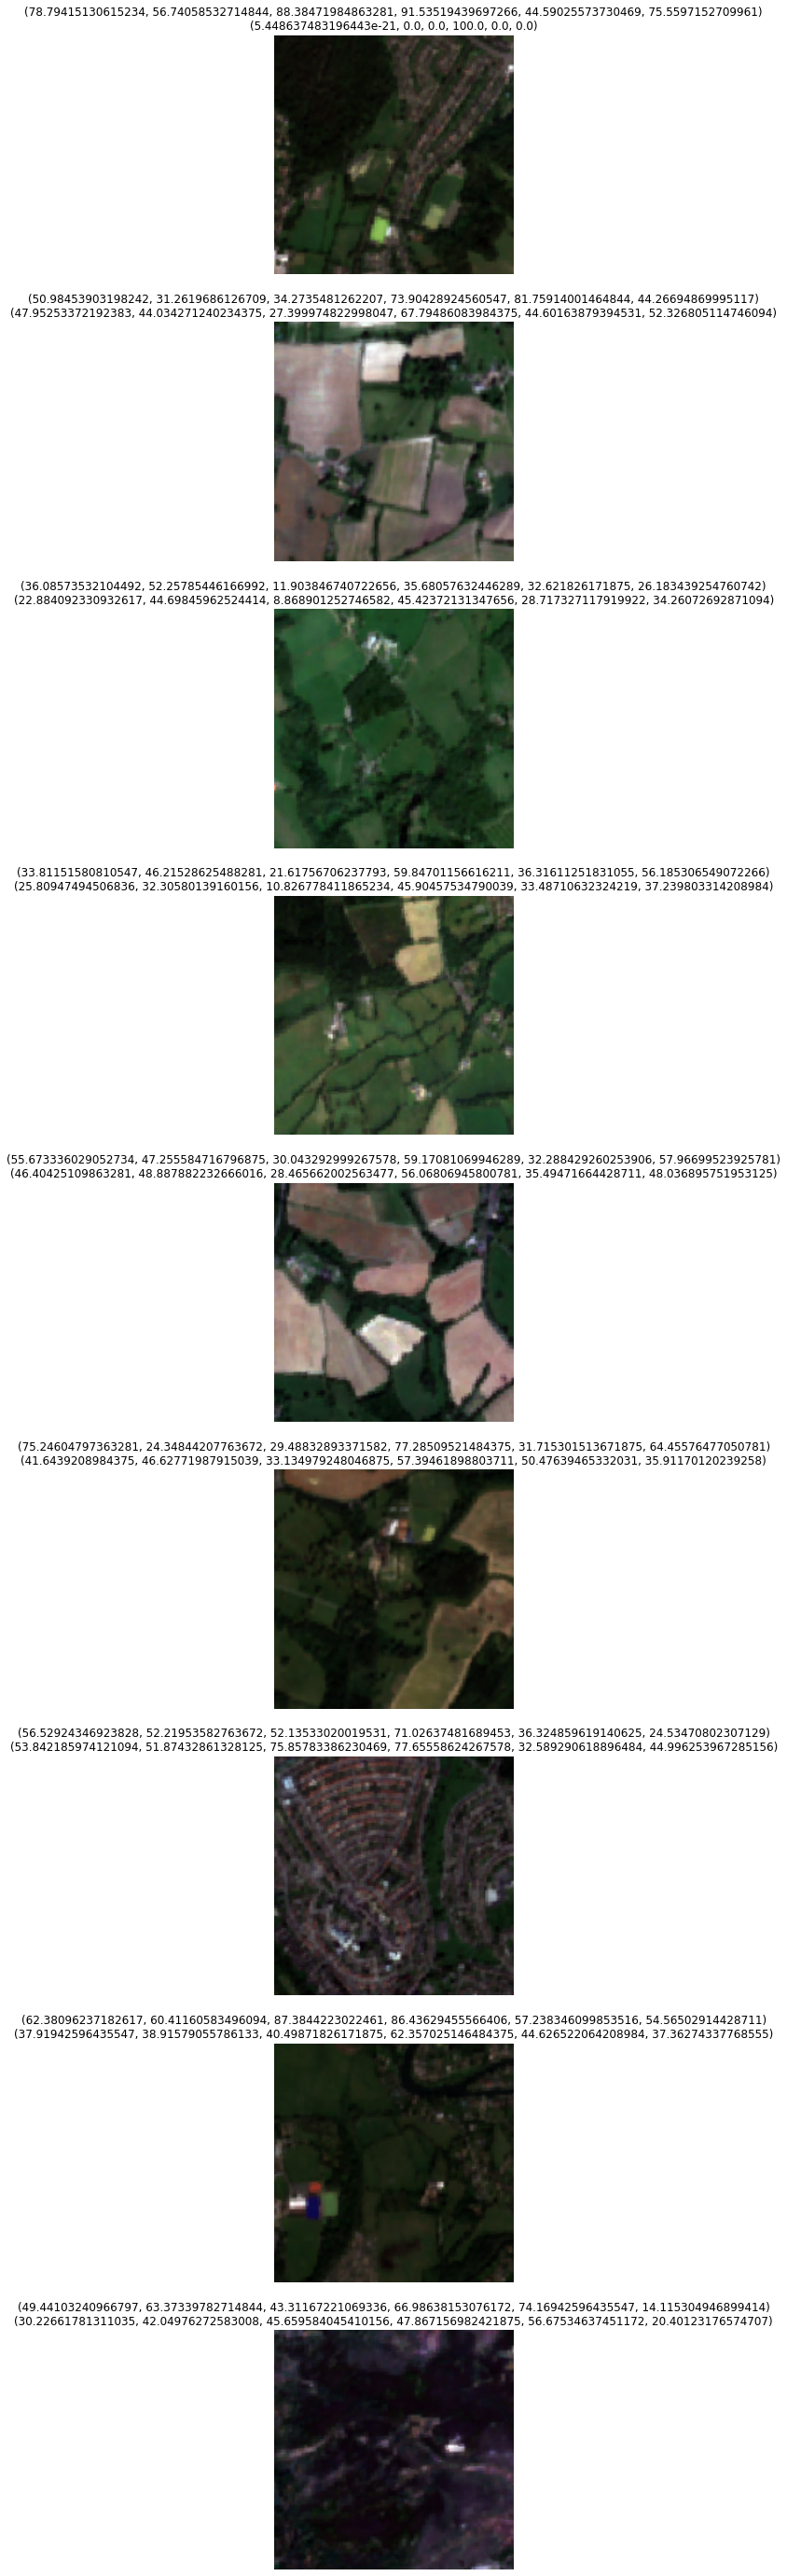

In [75]:
learn.show_results(ds_idx=1, nrows=9, max_n=9, figsize = (50,50))

In [76]:
interp = Interpretation.from_learner(learn)

In [77]:
interp.plot_top_losses(10)

Exception: ignored

### Export the model

In [ ]:
# Export model so we can use it for other things
# Note - this kills the model 
new_model = "mrghg_170221_opts"
learn.export(f"{c.model_dir}/{new_model}.pkl")

In [ ]:
# Import model and test to see if it hasn't broken in the export process. I have
# no idea if this'll happen, but it's worth testing. 
imported_learner = load_learner(f"{c.model_dir}/{c.model_name}.pkl")

In [ ]:
# Predict from imported learner
imported_learner.predict(f"{c.png_dir}/-0.73212695655741_51.2533785354393.png")

((3.3061301708221436,
  6.372119903564453,
  5.765547275543213,
  1.3745146989822388,
  3.039674997329712,
  1.802012324333191),
 tensor([3.3061, 6.3721, 5.7655, 1.3745, 3.0397, 1.8020]),
 tensor([3.3061, 6.3721, 5.7655, 1.3745, 3.0397, 1.8020]))

#### Notes on Image Predictions

A lower learning rate appears to cause slower training with more sophisticated conclusions. Sophistication also appears to arise from a deeper network, but I'm hitting a wall at roughly 0.6 rmse.

---

Currently, the networks are having some trouble defining more subtle characteristics of the images, which shows some flaws in my work. The network will need some supplemental information to accurately predict the greenhouse gas at this point. This may include the following:
- **Latitude/Longitude.** Geography may affect predictions - all the images in my current dataset are near London, meaning they have far more greenhouse gases than most places. To encode a knowledge of city geography into a neural net may take some work...
- **Property Value.** How valuable is this land? This could go some way to encoding city dynamics, as well as explaining where the land might be. If land is rural, but valuable, it's likely to be near major cities or airports. 
- **Nearby GHG Values.** Combined with wind direction, an understanding of source & direction of airflow may describe how areas inherit ghg's from elsewhere. An example of this would be the high concentration of NO<sub>2</sub> north of Heathrow Airport, which may be caused by common flight patterns heading north. 
- **Wind Direction.** See above. 
- **Land Use.** Depending on detail, this may help alleviate the "grey field/massive factory" issue described in my log. By proving that certain areas are rural, residential, or industrial, we can limit errors based on inferring purely visual information. If we can specifically define what a large grey box is doing, we can also come to more developed conclusions about its purpose. A recycling center, an oil refinery, and a brewery may all look similar from above, but information about what they _are_ will limit a neural network getting confused. 
- **Population Density/Economic Output.** This will work in a similar way to property value, where we can predict human activity and its effects on greenhouse gases. Economic output may have a complex relationship to GHG emissions that cannot be easily represented, depending on the form of industry. For example, an eco-tourist attraction may rely on its low carbon footprint for survival, whereas a petrol station relies on high carbon ouput. 
- **Land Height**

Effectively, this network recognises certain features of high-GHG land. Depending on sophistication, this may include airports, power plants, or other rare features, as well as recognising different types of wilderness or residential districts. This will be used to extract a feature set for a tabular recommender, which can then be used to find more accurate readings. 

### Tabular Recommender Training